In [1]:
#imports 

import os
import string
import re
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from IPython.core.display import display, HTML
from collections import Counter
import cufflinks as cf
cf.go_offline()

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print(train.shape)
print(test.shape)
print(train.info)
print(test.head())

(7613, 5)
(3263, 4)
<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The

In [3]:
missing = train.isnull().sum()  
missing[missing>0].sort_values(ascending=False).iplot(kind='bar',title='Null values present in train Dataset', color=['red'])

In [4]:
train.target.value_counts().iplot(kind='bar',text=['Fake', 'Real'], title='Comparing Tweet is a real disaster (1) or not (0)',color=['blue'])

In [5]:
print('Number of unique keywords: ', train['keyword'].nunique())
print('Percentage of tweets with keywords: ', len(train['keyword'].dropna())/ len(train) * 100)
train.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')

Number of unique keywords:  221
Percentage of tweets with keywords:  99.19873899908052


In [6]:
# comparing top keywords in disaster tweets vs non-disaster tweets

print('Top keywords in disaster tweets:')
print(train[train['target'] == 1]['keyword'].value_counts().head(), '\n')
print('Top keywords in non-disaster tweets:')
print(train[train['target'] == 0]['keyword'].value_counts().head())

Top keywords in disaster tweets:
wreckage       39
derailment     39
outbreak       39
typhoon        37
oil%20spill    37
Name: keyword, dtype: int64 

Top keywords in non-disaster tweets:
body%20bags    40
armageddon     37
harm           37
wrecked        36
deluge         36
Name: keyword, dtype: int64


In [7]:
#Making locations consistent and fixing the different variations

train.loc[train['location'].isin(['US', 'United States', 'United States of America']), 'location'] = 'USA'
train.loc[train['location'].isin(['United Kingdom', 'The UK']), 'location'] = 'UK'

# Apply the same to the test set
test.loc[test['location'].isin(['US', 'United States', 'United States of America']), 'location'] = 'USA'
test.loc[test['location'].isin(['United Kingdom', 'The UK']), 'location'] = 'UK'

print('Number of unique locations: ', train['location'].nunique())
print('Top tweet locations:')
location_counts = train['location'].value_counts().head()
location_counts
train.location.value_counts()[:20].iplot(kind='bar', title='Top 20 location in tweet', color='blue') 

Number of unique locations:  3336
Top tweet locations:


In [8]:
# Hashtags a lot of the time can give insights on a tweet, first we need to clean the data

# lowercase all text
train['text'] = train['text'].map(lambda text: text.lower())
test['text'] = test['text'].map(lambda text: text.lower())

# Find hastags with regex
train['hashtags'] = train['text'].map(lambda text: re.findall(r"#(\w+)", text))
test['hashtags'] = test['text'].map(lambda text: re.findall(r"#(\w+)", text))

# Remove hashtags symbols from the original text but keep the words
train['text'] = train['text'].map(lambda text: text.replace('#', ''))
test['text'] = test['text'].map(lambda text: text.replace('#', ''))

# Flatten hastags list and print most common
hashtags = pd.Series([tag for hashtags in train['hashtags'] for tag in hashtags])
print('Most common hashtags:')
hashtags.value_counts().head()

Most common hashtags:


news        76
hot         31
best        30
prebreak    30
islam       23
dtype: int64

Hashtags in disaster tweets:


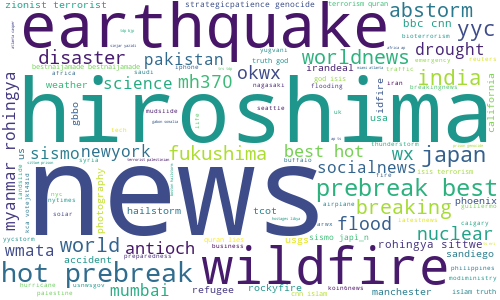

In [9]:
disaster_hashtags = pd.Series([tag for hashtags in train[train['target'] == 1]['hashtags'] for tag in hashtags])
wordcloud = WordCloud(background_color='white', width=500, height=300).generate(' '.join(disaster_hashtags))
print('Hashtags in disaster tweets:')
wordcloud.to_image()

Hashtags in non-disaster tweets:


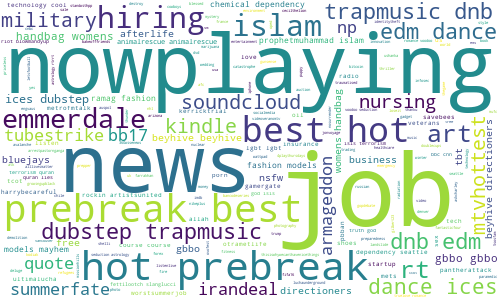

In [10]:
non_disaster_hashtags = pd.Series([tag for hashtags in train[train['target'] == 0]['hashtags'] for tag in hashtags])
wordcloud = WordCloud(background_color='white', width=500, height=300).generate(' '.join(non_disaster_hashtags))
print('Hashtags in non-disaster tweets:')
wordcloud.to_image()

In [11]:
# Using the mentions (@) to extract insghts from the tweet

# Find mentions with regex
train['mentions'] = train['text'].map(lambda text: re.findall(r"@(\w+)", text))
test['mentions'] = test['text'].map(lambda text: re.findall(r"@(\w+)", text))

# Remove mention symbols from the original text but keep the words
train['text'] = train['text'].map(lambda text: text.replace('@', ''))
test['text'] = test['text'].map(lambda text: text.replace('@', ''))

# Flatter mentions list and print most common
mentions = pd.Series([mention for mentionslist in train['mentions'] for mention in mentionslist])
mentions.value_counts().head()

youtube         83
arianagrande    11
foxnews          9
potus            9
change           9
dtype: int64

In [12]:
# Removing urls from the text as they are useless

# Find URLs with regex
train['url'] = np.NaN
train['url_search'] = train['text'].map(lambda text: re.search('(?P<url>https?://[^\s]+)', text))
train.loc[~train['url_search'].isnull(), 'url'] = train[~train['url_search'].isnull()]['url_search'].map(lambda result: result.group('url'))
del train['url_search']

test['url'] = np.NaN
test['url_search'] = test['text'].map(lambda text: re.search('(?P<url>https?://[^\s]+)', text))
test.loc[~test['url_search'].isnull(), 'url'] = test[~test['url_search'].isnull()]['url_search'].map(lambda result: result.group('url'))
del test['url_search']

# Extract hostname from URLs
train.loc[~train['url'].isnull(),'host'] = train['url'].dropna().map(lambda s: s.split('://')[-1].split('/')[0].split('?')[0] if s else np.NaN)
test.loc[~test['url'].isnull(), 'host'] = test['url'].dropna().map(lambda s: s.split('://')[-1].split('/')[0].split('?')[0] if s else np.NaN)


# Remove URLs from tweet text
train['text'] = train['text'].map(lambda text: re.sub('(?P<url>https?://[^\s]+)', '', text))
test['text'] = test['text'].map(lambda text: re.sub('(?P<url>https?://[^\s]+)', '', text))

# Print most common
print('Most common URLs:')
train['host'].value_counts().head()
train['url'] = np.NaN
train['url_search'] = train['text'].map(lambda text: re.search('(?P<url>https?://[^\s]+)', text))
train.loc[~train['url_search'].isnull(), 'url'] = train[~train['url_search'].isnull()]['url_search'].map(lambda result: result.group('url'))
del train['url_search']

test['url'] = np.NaN
test['url_search'] = test['text'].map(lambda text: re.search('(?P<url>https?://[^\s]+)', text))
test.loc[~test['url_search'].isnull(), 'url'] = test[~test['url_search'].isnull()]['url_search'].map(lambda result: result.group('url'))
del test['url_search']

# Extract hostname from URLs
train.loc[~train['url'].isnull(),'host'] = train['url'].dropna().map(lambda s: s.split('://')[-1].split('/')[0].split('?')[0] if s else np.NaN)
test.loc[~test['url'].isnull(), 'host'] = test['url'].dropna().map(lambda s: s.split('://')[-1].split('/')[0].split('?')[0] if s else np.NaN)


# Remove URLs from tweet text
train['text'] = train['text'].map(lambda text: re.sub('(?P<url>https?://[^\s]+)', '', text))
test['text'] = test['text'].map(lambda text: re.sub('(?P<url>https?://[^\s]+)', '', text))

# Print most common
print('Most common URLs:')
train['host'].value_counts().head()

Most common URLs:
Most common URLs:


t.co                     3968
youtu.                      1
t.û_                       1
www.informationng.com       1
Name: host, dtype: int64

Already cleaned the data by
1. converted to text to all lowercase
2. removing @ and #
3. remoing urls 

In [13]:
# Converting words to lemma 

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenize text, filter out punctuations and stopwords and lemmatize the words
def get_words(text):
    words = [word.translate(str.maketrans('', '', string.punctuation)) for word in word_tokenize(text)]
    words = [word for word in words if word.isalpha() and word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return words


train['words'] = train['text'].map(lambda text: get_words(text))
test['words'] = test['text'].map(lambda text: get_words(text))

# Print top words
words = pd.Series([word for wordlists in train['words'] for word in wordlists])
print('Most common words (lemmatized) :')
words.value_counts().head()

Most common words (lemmatized) :


nt      446
fire    351
like    347
amp     344
get     255
dtype: int64

In [14]:
# cleaned data with extracted features
train.head(3)

,id,keyword,location,text,target,hashtags,mentions,url,host,words
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,[earthquake],[],NaN,NaN,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,[],[],NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[],NaN,NaN,"[resident, asked, shelter, place, notified, of..."


In [15]:
# The words in the tweet are mapped to numeric vectors using CountVectorizer.
# Vectorize the training set
word_vectorizer = CountVectorizer()
X_train = word_vectorizer.fit_transform(train['words'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(test['words'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is diaster tweet
y_train = train['target']

X_train.shape

(7613, 14635)

In [16]:
# Using Naive Bayes classifier to estimate the likelihood of a tweet being a disaster tweet
from sklearn.metrics import accuracy_score
clf = BernoulliNB()
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.7393914169024963


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [21]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_test = clf.predict(X_test)
output = pd.DataFrame()
output['id'] = test['id']
output['target'] = y_test
output.to_csv('submission.csv', index=False)





/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [ ]:
from sklearn import svm
supp = svm.SVC()

supp.fit(X_train, y_train)
y_test = supp.predict(X_test)
output = pd.DataFrame()
output['id'] = test['id']
output['target'] = y_test
output.to_csv('submission_svm.csv', index=False)

In [23]:
from sklearn.svm import LinearSVC
linsupp = LinearSVC(dual= False, max_iter= 10000, random_state= 1)

linsupp.fit(X_train, y_train)
y_test = linsupp.predict(X_test)
output = pd.DataFrame()
output['id'] = test['id']
output['target'] = y_test
output.to_csv('submission_linsvm.csv', index=False)

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_test = rfc.predict(X_test)
output = pd.DataFrame()
output['id'] = test['id']
output['target'] = y_test
output.to_csv('submission_rfc.csv', index=False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [26]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_test = nb.predict(X_test)
output = pd.DataFrame()
output['id'] = test['id']
output['target'] = y_test
output.to_csv('submission_nb.csv', index=False)

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7,weights = 'distance', algorithm = 'brute')

knn.fit(X_train,y_train)
y_test = knn.predict(X_test)
output = pd.DataFrame()
output['id'] = test['id']
output['target'] = y_test
output.to_csv('submission_knn.csv', index=False)

In [24]:
solution = pd.read_csv("submission.csv")
print(solution)

         id  target
0         0       1
1         2       0
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]
